In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import random

In [17]:
df = pd.read_csv('nacas.csv')
np.unique(df['naca'])

array(['0006', '0008', '000834', '0010', '001034', '001035', '001064',
       '001065', '001066', '001234', '001264', '0015', '0018', '0021',
       '0024', '1408', '1410', '1412', '16006', '16009', '16012', '16015',
       '16018', '16021', '23012', '23015', '23018', '23021', '23024',
       '2408', '2410', '2411', '2412', '2415', '2418', '2421', '2424',
       '4412', '4415', '4418', '4421', '4424', '63206', '63209', '632615',
       '632a015', '633018', '633218', '633418', '633618', '634221',
       '634421', '63a210', '641112', '6412', '64206', '64208', '64209',
       '64210', '642215', '642415', '643218', '643418', '643618',
       '644221', '644421', '64a010', '64a210', '64a410', '651212',
       '651212a06', '651412', '65206', '65209', '65210', '652215',
       '652415', '652415a05', '653218', '65410', '654221', '654421',
       '654421a05', '66-018', '661212', '66206', '66209', '66210',
       '662215', '662415', '663218', '663418', '664221', '671215',
       '747a315', '747a4

In [18]:
df = pd.read_csv('nacas.csv')
NACAS = ['4415','4412','6412','2411', 'clarky']
df = df.loc[(df['naca'] == '4415') | (df['naca'] == '4412') | (df['naca'] == '6412') | (df['naca'] == '2411') | (df['naca'] == 'clarky')]

In [19]:
def Cx_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CD'])

def Cz_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CL'])

def Alpha_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['alpha'])

Text(0.5, 1.0, 'Cz 4412 discret')

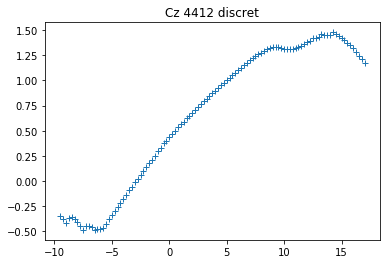

In [20]:
x = Alpha_data('4412', 100000)
y = Cz_data('4412',100000)
plt.plot(x,y,"+")
plt.title('Cz 4412 discret')

In [21]:
spl = InterpolatedUnivariateSpline(x, y, k=5)

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

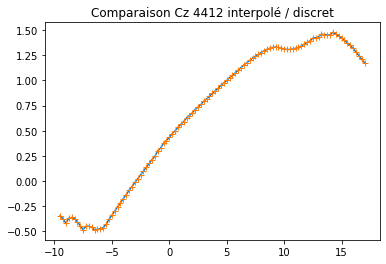

In [22]:
plt.plot(x,spl(x))
plt.plot(x,y,"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

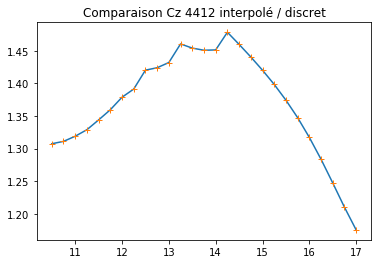

In [23]:
plt.plot(x[80:],spl(x[80:]))
plt.plot(x[80:],y[80:],"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

In [24]:
def Cx_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cx_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5, ext = 3)
    return spl

def Cz_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cz_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5, ext = 3)
    return spl

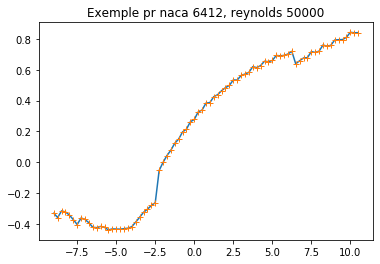

In [25]:
plt.title('Exemple pr naca 6412, reynolds 50000')
plt.plot(Alpha_data('6412',50000),Cz_spline('6412',50000)(Alpha_data('6412',50000)))
plt.plot(Alpha_data('6412',50000),Cz_data('6412',50000),"+")

In [26]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
import random

In [27]:
def simu(naca = '4412', N_elements = 50, r_min = 0.01, r_max = 0.07):

    # Créations des fonctions continues Cx, Cz
    func_Cx = dict()
    func_Cz = dict()
    for reynolds in [50000, 100000, 200000, 500000, 1000000]:
        func_Cx[str(reynolds)] = Cx_spline(naca, reynolds)
        func_Cz[str(reynolds)] = Cz_spline(naca, reynolds)

    # Discrétisation des rayons
    rayons = np.linspace(r_min, r_max, N_elements)

    # Calcul du pas associé
    delta = rayons[1]-rayons[0]

    n = 10000/60

    # Vitesse de flux d'air en vol stat définie par Froude : (sqrt(mg/8rhoS) pour une hélice entière)

    v_froude = np.sqrt(0.5 * 9.81 / (8 * (r_max**2-r_min**2)* np.pi))

    # Angle dû à la vitesse "froude"

    def beta(r):
        angle_rad = np.arctan(v_froude/(2*np.pi*n*r))
        angle_deg = angle_rad/np.pi*180
        return angle_deg

    # Fonction de vitesse
    def speed(r):
        v_t = 2*np.pi*r*n
        return np.sqrt(v_froude**2+v_t**2)

    # Fonction de surface d'un trapèze
    def area(l1, l2):
        return (np.abs(l1)+np.abs(l2))/2 * delta

    # Plus proche voisin d'un élément dans une liste

    def NN(element, L):
        l = len(L)
        cand = 0
        tol = np.abs(L[cand])+np.abs(element)
        for k in range(l):
            if np.abs(L[k]-element)<tol:
                cand = k
                tol = np.abs(L[k]-element)
        return cand

    # Fonction qui associe le Reynolds le plus proche du vrai Reynolds :

    def Reynolds(vitesse, L_c):
        mu = 1.56 * 10**-5
        all_reys = [50000,100000,500000,1000000]
        return all_reys[NN(L_c*vitesse/mu, all_reys)]

    # Calcul du Cx, Cz pour une géométrie donnée : 

    def C_global(thetas, chords):
        sz = 0
        sx = 0
        div = 0
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i], chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            C_x = func_Cx[str(reynolds)]
            sx+= v_i**2 * S_i * C_x(thetas[i]-beta(rayons[i]))
            C_z = func_Cz[str(reynolds)]
            sz+= v_i**2 * S_i * C_z(thetas[i]-beta(rayons[i]))

            div+= v_i**2 * S_i

        Cz = sz/div
        Cx = sx/div
        return Cz, Cx

    # Calcul du Cx induit pour une géométrie donnée :
    
    def C_induit(thetas, chords, Cz):
        e = 0.8
        S_tot = 0
        for i in range(N_elements-1):
            c_i = chords[i]
            c_i2 = chords[i+1]
            S_tot+=area(c_i,c_i2)

        allongement = (r_max - r_min)**2 / S_tot
        C_xi = Cz**2/(np.pi * allongement * e)
        return C_xi
    # Calcul de la puissance de trainee (contrainte) :

    def puissance_trainee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        P_tot = 0
        pho_air = 1.3
        S_tot = 0
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i],chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_x = func_Cx[str(reynolds)]
            Cx_loc = f_C_x(thetas[i]-beta(rayons[i]))
            P_tot += 2 * 1/2 * pho_air * v_i**3 * Cx_loc * S_i
            S_tot += S_i
        Cz, Cx = C_global(thetas, chords)
        C_xi = C_induit(thetas,chords, Cz)
        v_moy = np.mean(speed(rayons))
        P_tot += 2 * 1/2 * pho_air * v_moy**3 * C_xi * S_tot
        return P_tot
    
    def puissance_poussee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        P_tot = 0
        pho_air = 1.3
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i],chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_z = func_Cz[str(reynolds)]
            Cz_loc = f_C_z(thetas[i]-beta(rayons[i]))
            P_tot += 2 * 1/2 * pho_air * v_i**3 * Cz_loc * S_i
        return P_tot

    def puissance_totale(args):
        P = puissance_poussee(args) + puissance_trainee(args)
        return P

    def force_poussée(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        F_tot = 0
        pho_air = 1.3
        Cz, Cx = C_global(thetas, chords)
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i], chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_z = func_Cz[str(reynolds)]
            Cz = f_C_z(thetas[i]-beta(rayons[i]))
            F_tot+= 1/2 * pho_air * v_i**2 * S_i * Cz
        return 2* F_tot

    def fonction_vrillage(args):
        #return args[2] * rayons**2 + args[1] * rayons + args[0]
        return args[0:N_elements]
    
    def fonction_corde(args):
        #return args[-1] * rayons**3 + args[-2] * rayons**2 + args[-3] * rayons + args[-4]
        return args[N_elements:]

    def func2optim(args):
        return -force_poussée(args)

    # Création de la contrainte :

    cons1 = NonlinearConstraint(puissance_totale, 0, 60)

    cons2 = NonlinearConstraint(fonction_corde,np.ones(N_elements)*0.008,np.ones(N_elements)*0.014)

    cons3 = NonlinearConstraint(fonction_vrillage,np.zeros(N_elements),np.ones(N_elements)*60)

    # Initialisation des coefficients : 

    #poly_vrillage_0 = [10,0,0]
    #poly_corde_0 = [0.01 for k in range(N_elements)]
    #poly_corde_0 = [0.01, 0, 0, 0]

    poly_vrillage_0 = [beta(rayons[k]) for k in range(N_elements)]
    poly_corde_0 = [0.02 for k in range(N_elements)]


    x_init = np.array(poly_vrillage_0+poly_corde_0)

    # Exécution de l'optimisation :

    t_0 = time.time()

    opt = dict()
    opt['maxiter'] = 500
    opt['disp'] = True

    res = minimize(func2optim, x0 = x_init, constraints = [cons1,cons2,cons3], options = opt)

    print(f'Run {naca} in {int(time.time()-t_0)}s')
    print(res['success'], "in", res['nit'],"steps")

    fig, ax = plt.subplots(2,1, figsize=(10, 6))
    ax[0].plot(rayons,fonction_corde(res['x']))
    ax[0].set_title('Fonction de corde')
    ax[0].axis('equal')
    ax[0].fill_between(rayons, fonction_corde(res['x']), color='#539ecd')
    ax[1].set_title('Fonction de vrillage')
    ax[1].plot(rayons,fonction_vrillage(res['x']))

    val = res['fun']
    print(f"Force de portance {-val}N")
    args = res['x']
    print(f"Puissance de trainée = {puissance_trainee(args)}W")
    print(f"Puissance de portance = {puissance_poussee(args)}W")
    return rayons, res

In [154]:
for naca in NACAS:
    rayons, res = simu(naca = naca, N_elements = 100)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.957638786618592
            Iterations: 50
            Function evaluations: 5786
            Gradient evaluations: 46
Run 4415 in 69s
False in 50 steps
Force de portance 0.957638786618592N
Puissance de trainée = 5.9693313542164335W
Puissance de portance = 53.75024508297172W
More than 3*n iterations in LSQ subproblem    (Exit mode 3)
            Current function value: -0.9477640361079792
            Iterations: 113
            Function evaluations: 14149
            Gradient evaluations: 112
Run 4412 in 164s
False in 113 steps
Force de portance 0.9477640361079792N
Puissance de trainée = 6.254246166488651W
Puissance de portance = 54.813061038284765W


KeyboardInterrupt: 